# Do You Want To Build A Forest?

In [12]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['lines.linewidth'] = 2.5

import pandas as pd
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 20)

### What is a tree?

In [138]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree

In [139]:
iris = load_iris()
clf = DecisionTreeClassifier(max_depth=3).fit(iris.data, iris.target)

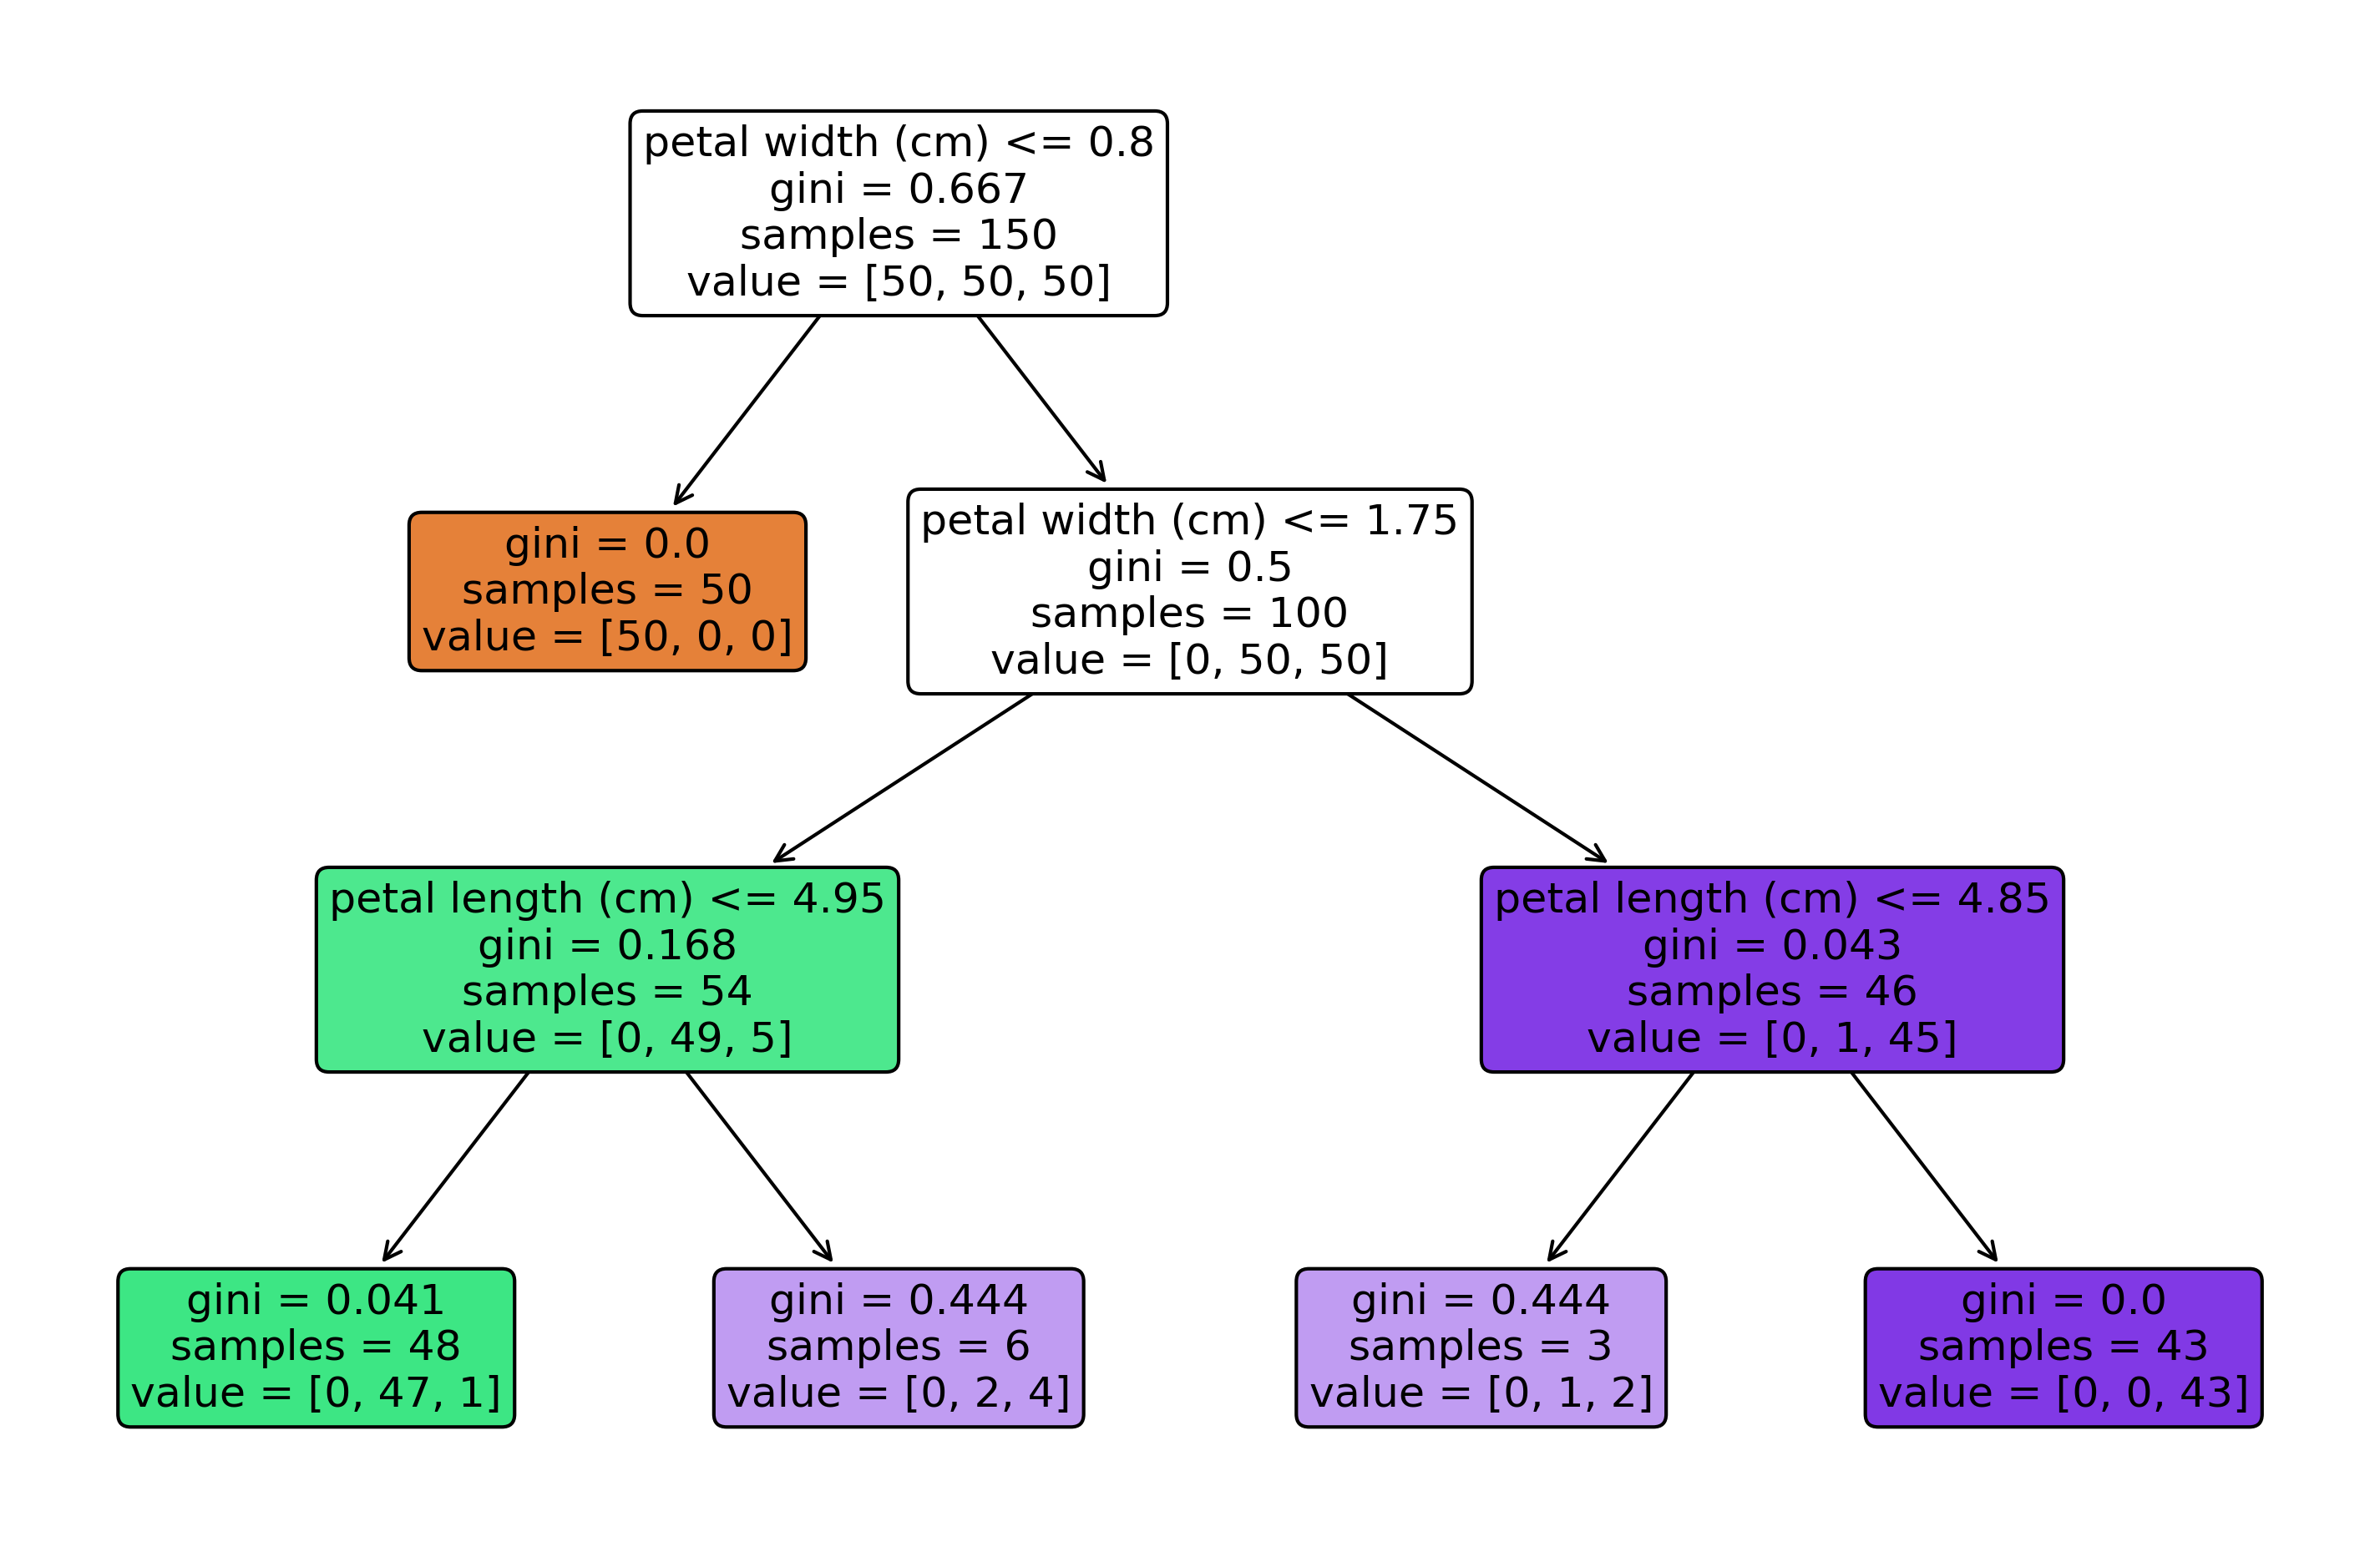

In [140]:
fig, ax = plt.subplots(dpi=300)
_ = plot_tree(clf, filled=True, feature_names=iris.feature_names, rounded=True, ax=ax)

In [10]:
fig.savefig("images/tree_iris.png", transparent=True)

## Forest (Pruning)

In [61]:
from sklearn.datasets import fetch_california_housing
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

housing = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    housing.data, housing.target, random_state=0
)

rf = RandomForestRegressor(n_jobs=-1, random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [62]:
np.mean([est.tree_.node_count for est in rf.estimators_])

18736.58

In [63]:
rf.score(X_test, y_test)

0.7942963762007227

In [72]:
rf_pruned = RandomForestRegressor(ccp_alpha=1e-5, n_jobs=-1, random_state=0)
rf_pruned.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=1e-05, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [73]:
np.mean([est.tree_.node_count for est in rf_pruned.estimators_])

5687.18

In [74]:
rf_pruned.score(X_test, y_test)

0.793849667415543

## Permutation importance vs Feature

In [291]:
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

In [292]:
X, y = fetch_openml("titanic", version=1, as_frame=True, return_X_y=True)

In [293]:
rng = np.random.RandomState(seed=42)
X['random_cat'] = rng.randint(3, size=X.shape[0])
X['random_num'] = rng.randn(X.shape[0])

In [294]:
X

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest,random_cat,random_num
0,1.0,"Allen, Miss. Elisabeth Walton",female,29.0000,0.0,0.0,24160,211.3375,B5,S,2,NaN,"St Louis, MO",2,-1.110576
1,1.0,"Allison, Master. Hudson Trevor",male,0.9167,1.0,2.0,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON",0,1.752270
2,1.0,"Allison, Miss. Helen Loraine",female,2.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",2,0.935678
3,1.0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,135.0,"Montreal, PQ / Chesterville, ON",2,1.271555
4,1.0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1.0,2.0,113781,151.5500,C22 C26,S,None,NaN,"Montreal, PQ / Chesterville, ON",0,0.721672
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3.0,"Zabour, Miss. Hileni",female,14.5000,1.0,0.0,2665,14.4542,None,C,None,328.0,None,2,-0.971657
1305,3.0,"Zabour, Miss. Thamine",female,NaN,1.0,0.0,2665,14.4542,None,C,None,NaN,None,2,-1.379618
1306,3.0,"Zakarian, Mr. Mapriededer",male,26.5000,0.0,0.0,2656,7.2250,None,C,None,304.0,None,1,-0.626717
1307,3.0,"Zakarian, Mr. Ortin",male,27.0000,0.0,0.0,2670,7.2250,None,C,None,NaN,None,1,0.862393


In [295]:
categorical_columns = ['pclass', 'sex', 'embarked', 'random_cat']
numerical_columns = ['age', 'sibsp', 'parch', 'fare', 'random_num']

X = X[categorical_columns + numerical_columns]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42)

categorical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
numerical_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

preprocessing = ColumnTransformer(
    [('cat', categorical_pipe, categorical_columns),
     ('num', numerical_pipe, numerical_columns)])

rf = Pipeline([
    ('preprocess', preprocessing),
    ('classifier', RandomForestClassifier(random_state=42))
])
rf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('preprocess',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('cat',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value='missing',
                                                                                 missing_values=nan,
                                                                                 strategy='constant',
                                                        

In [296]:
print("RF train accuracy: %0.3f" % rf.score(X_train, y_train))
print("RF test accuracy: %0.3f" % rf.score(X_test, y_test))

RF train accuracy: 1.000
RF test accuracy: 0.817


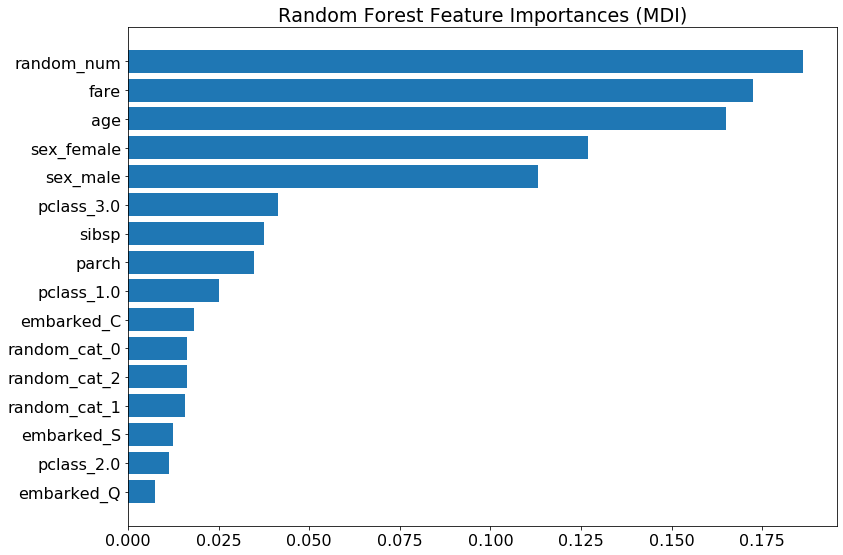

In [297]:
ohe = (rf.named_steps['preprocess']
         .named_transformers_['cat']
         .named_steps['onehot'])
feature_names = ohe.get_feature_names(input_features=categorical_columns)
feature_names = np.r_[feature_names, numerical_columns]

tree_feature_importances = (
    rf.named_steps['classifier'].feature_importances_)
sorted_idx = tree_feature_importances.argsort()

y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, tree_feature_importances[sorted_idx])
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_yticks(y_ticks)
ax.set_title("Random Forest Feature Importances (MDI)")
fig.tight_layout()

In [298]:
fig.savefig("images/random_forst_feature_importance.png", dpi=300, transparent=True)

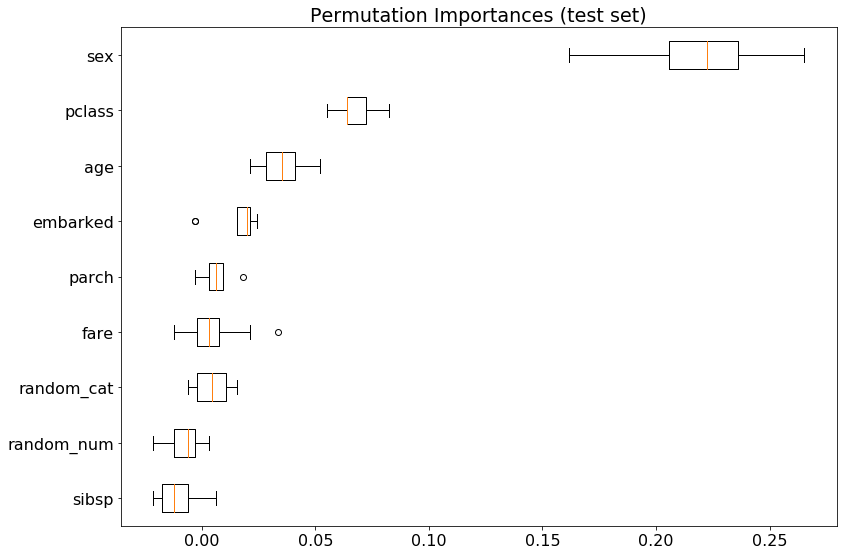

In [299]:
result = permutation_importance(rf, X_test, y_test, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()

In [300]:
fig.savefig("images/permutation_importance_test.png", dpi=300, transparent=True,
            bbox_inches="tight")

Text(0.5, 1.0, 'Permutation Importances (train set)')

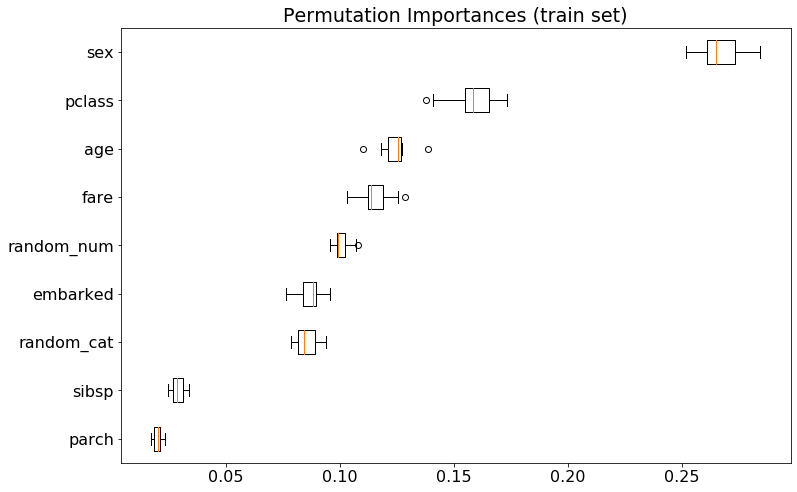

In [301]:
result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X_train.columns[sorted_idx])
ax.set_title("Permutation Importances (train set)")

In [302]:
fig.savefig("images/permutation_importance_train.png", dpi=300, transparent=True,
            bbox_inches="tight")

## Permutation Importance

In [55]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier

In [233]:
X, y = make_classification(n_features=4, random_state=0)

In [234]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [235]:
tree = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [236]:
result = permutation_importance(tree, X_train, y_train, n_repeats=30)

Text(0.5, 1.0, 'Permutation Importances (train set)')

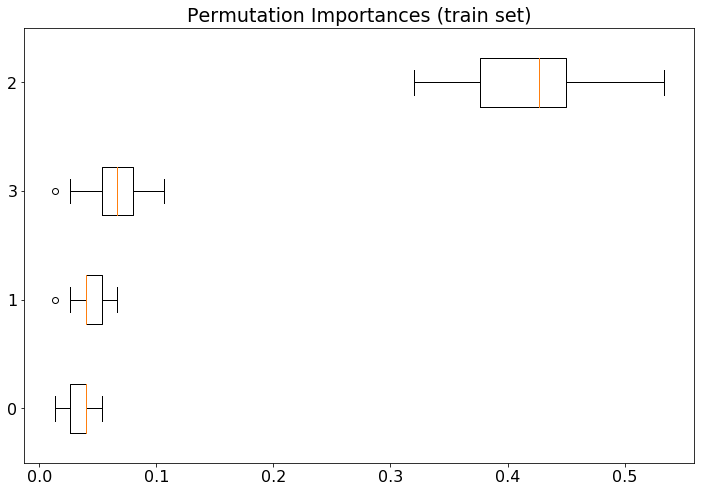

In [237]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False)
ax.set_yticklabels(sorted_idx)
ax.set_title("Permutation Importances (train set)")

In [238]:
fig.savefig("images/permutation_importance_example.png", transparent=True, dpi=300)

In [61]:
tree.score(X_test, y_test)

0.8

In [245]:
X = np.c_[X, X[:, 2]]

In [246]:
X.shape

(100, 5)

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [248]:
tree2 = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [249]:
result = permutation_importance(tree2, X_train, y_train, n_jobs=1, n_repeats=30)

Text(0.5, 1.0, 'Permutation Importances (train set)')

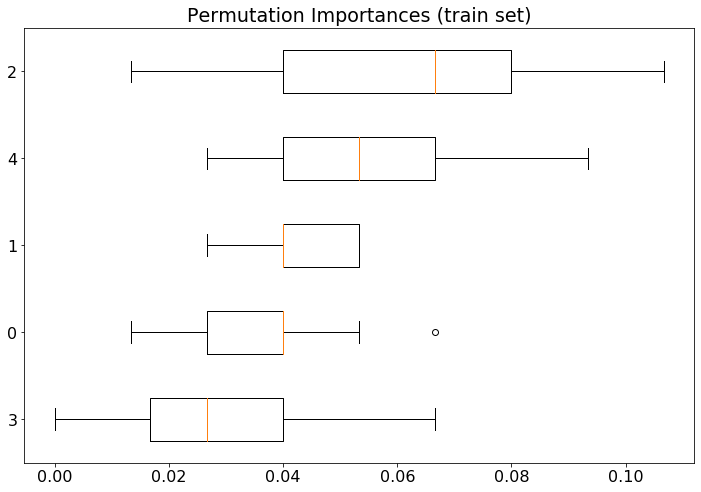

In [250]:
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False)
ax.set_yticklabels(sorted_idx)
ax.set_title("Permutation Importances (train set)")

In [252]:
fig.savefig("images/permutation_importance_duplicate_feature.png", transparent=True, dpi=300)

In [243]:
tree2.score(X_test, y_test)

0.8

## Permutation Importance with Multicollinear or Correlated Features

In [318]:
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

from sklearn.datasets import load_breast_cancer
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

In [319]:
data = load_breast_cancer()
X, y = data.data, data.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
print("Accuracy on test data: {:.2f}".format(clf.score(X_test, y_test)))

Accuracy on test data: 0.97


Text(0.5, 1.0, 'Permutation Importance with correlated features')

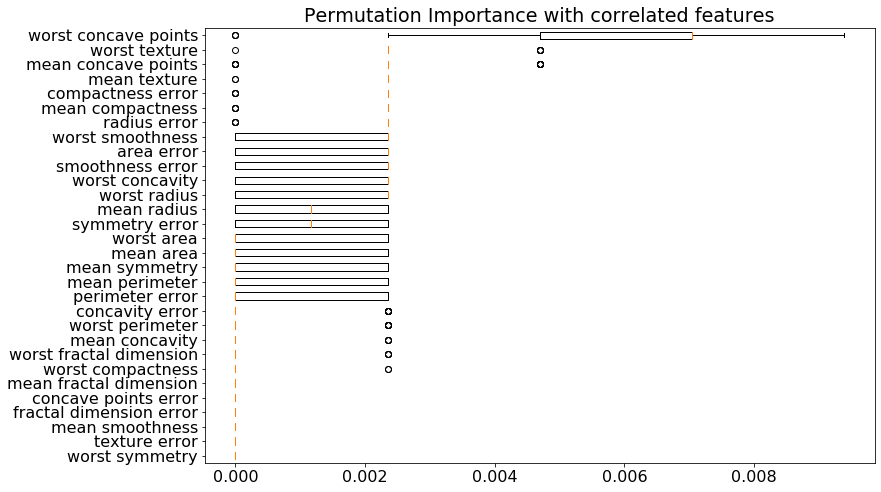

In [320]:
result = permutation_importance(clf, X_train, y_train, n_repeats=30,
                                random_state=42)
perm_sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
_ = ax.boxplot(result.importances[perm_sorted_idx].T, vert=False,
               labels=data.feature_names[perm_sorted_idx])
ax.set_title("Permutation Importance with correlated features")

In [321]:
fig.savefig("images/permutation_correlated_features.png", transparent=True, dpi=300,
            bbox_inches="tight")

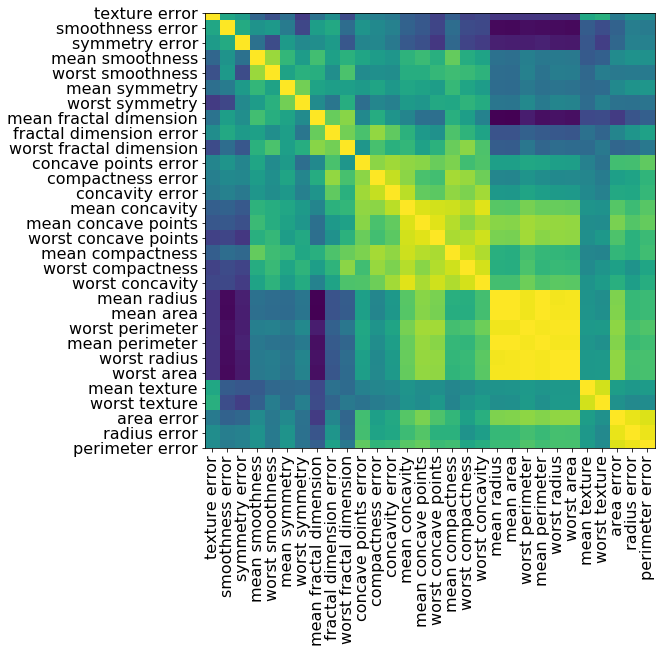

In [309]:
fig, ax = plt.subplots()
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=data.feature_names,
                              leaf_rotation=90, no_plot=True)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax.set_xticks(dendro_idx)
ax.set_yticks(dendro_idx)
ax.set_xticklabels(dendro['ivl'], rotation='vertical')
_ = ax.set_yticklabels(dendro['ivl'])

In [310]:
fig.savefig("images/correlation_matrix.png", transparent=True, dpi=300,
            bbox_inches="tight")

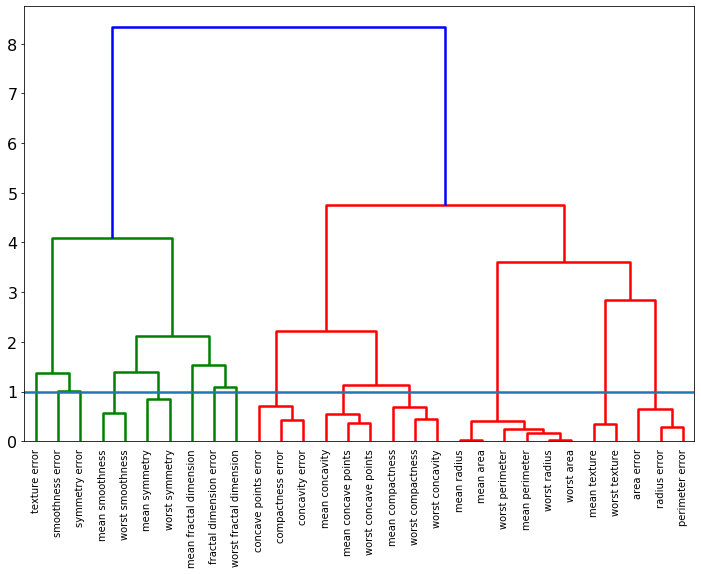

In [311]:
fig, ax = plt.subplots()
dendro = hierarchy.dendrogram(corr_linkage, labels=data.feature_names, ax=ax,
                              leaf_rotation=90)
ax.plot(ax.get_xlim(), [1, 1])

In [312]:
fig.savefig("images/dendrogram.png", transparent=True, dpi=300,
            bbox_inches="tight")

In [387]:
cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]
selected_feature_names = data.feature_names[selected_features]

X_train_sel = X_train[:, selected_features]
X_test_sel = X_test[:, selected_features]

In [388]:
clf_sel = RandomForestClassifier(n_estimators=100, random_state=42)
clf_sel.fit(X_train_sel, y_train)
print("Accuracy on test data with features removed: {:.2f}".format(
      clf_sel.score(X_test_sel, y_test)))

Accuracy on test data with features removed: 0.97


In [328]:
result = permutation_importance(clf_sel, X_train_sel, y_train, n_repeats=30,
                                random_state=42)

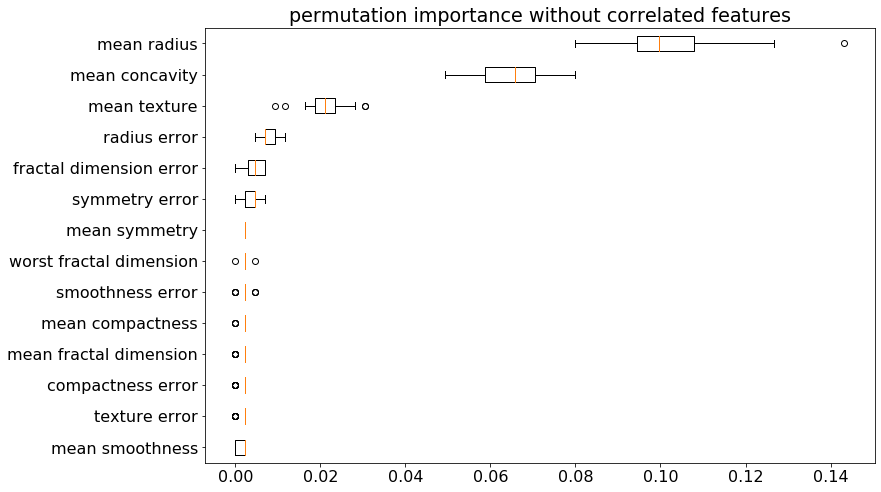

In [329]:
perm_sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
_ = ax.boxplot(result.importances[perm_sorted_idx].T, vert=False,
               labels=selected_feature_names[perm_sorted_idx])
_ = ax.set_title("permutation importance without correlated features")

In [330]:
fig.savefig("images/permutation_without_correlated_features.png",
            transparent=True, dpi=300, bbox_inches="tight")

## Parital Dependence

### Example

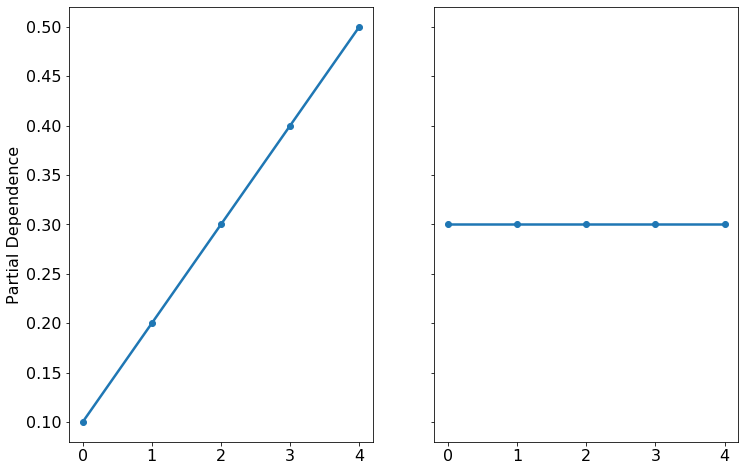

In [421]:
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
ax1.set_ylabel("Partial Dependence")
ax1.plot(range(5), np.arange(0.1, 0.6, 0.1), marker='o')
_ = ax2.plot(range(5), [0.3]*5, marker='o')


In [422]:
fig.savefig("images/partial_dependence_example.png", transparent=True, dpi=300)

In [425]:
from sklearn.inspection import plot_partial_dependence
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.pipeline import make_pipeline

In [426]:
hist = make_pipeline(HistGradientBoostingClassifier())
hist.fit(X_train_sel, y_train)

Pipeline(memory=None,
         steps=[('histgradientboostingclassifier',
                 HistGradientBoostingClassifier(l2_regularization=0.0,
                                                learning_rate=0.1, loss='auto',
                                                max_bins=255, max_depth=None,
                                                max_iter=100, max_leaf_nodes=31,
                                                min_samples_leaf=20,
                                                n_iter_no_change=None,
                                                random_state=None, scoring=None,
                                                tol=1e-07,
                                                validation_fraction=0.1,
                                                verbose=0, warm_start=False))],
         verbose=False)

In [427]:
hist.score(X_test_sel, y_test)

0.965034965034965

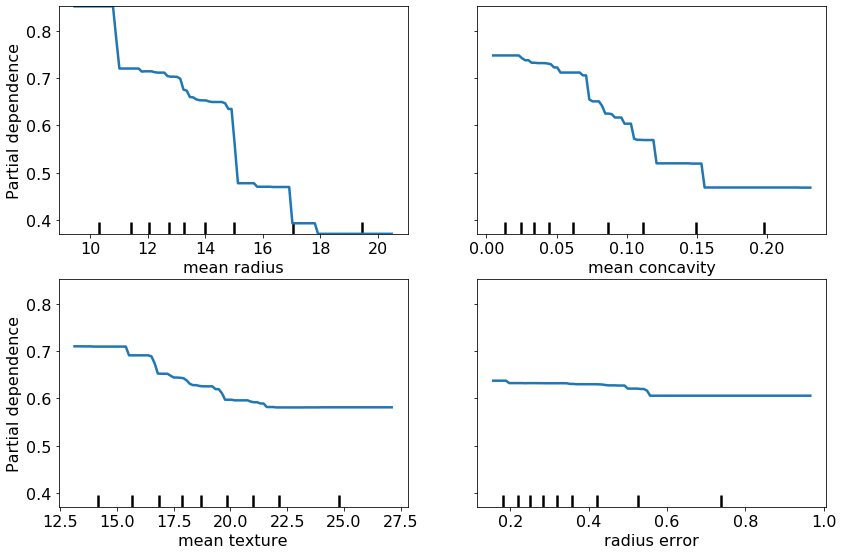

In [428]:
disp = plot_partial_dependence(hist, X_train_sel, n_cols=2,
                               features=['mean radius', 'mean concavity',
                                         'mean texture', 'radius error'],
                               feature_names=selected_feature_names)
disp.figure_.tight_layout()

In [429]:
disp.figure_.savefig("images/partial_dependence_cancer_data.png", transparent=True,
                     dpi=300)

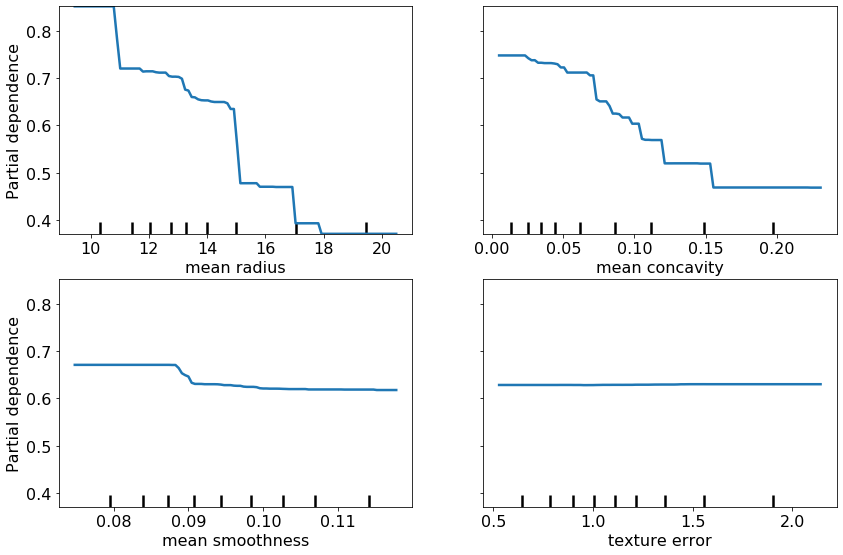

In [430]:
disp = plot_partial_dependence(hist, X_train_sel, n_cols=2,
                               features=['mean radius', 'mean concavity',
                                         'mean smoothness', 'texture error'],
                               feature_names=selected_feature_names)
disp.figure_.tight_layout()

In [431]:
disp.figure_.savefig("images/partial_dependence_cancer_data_with_last.png", transparent=True,
            dpi=300)

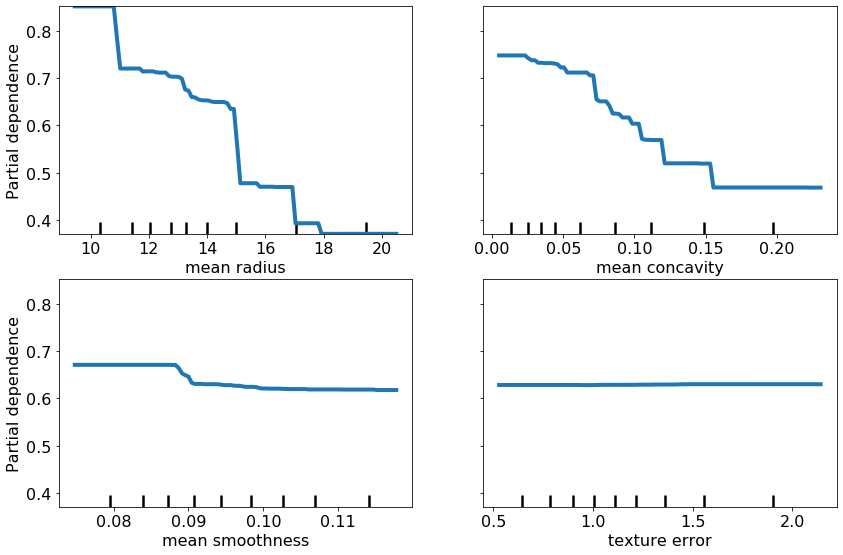

In [432]:
disp.plot(n_cols=2, line_kw={'linewidth': 4})
disp.figure_.tight_layout()

In [433]:
disp.figure_.savefig("images/partial_dependence_cancer_linewith_4.png", transparent=True,
                    dpi=300)

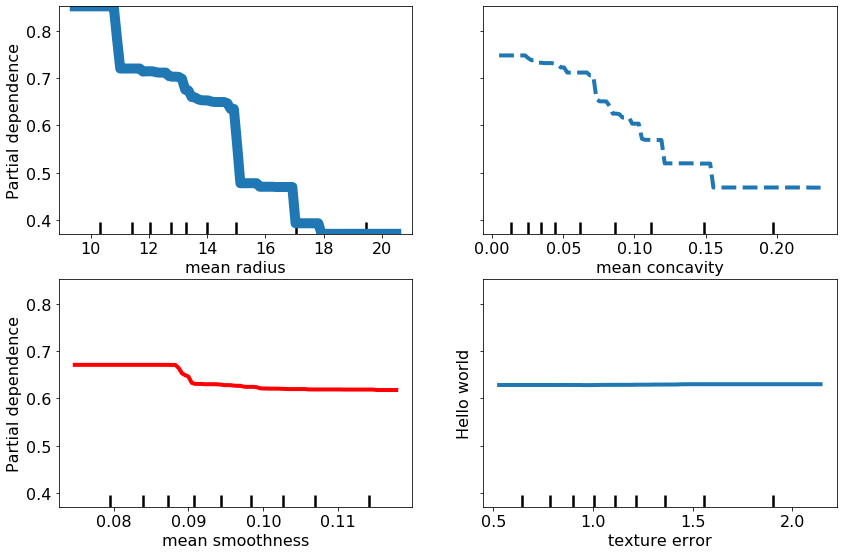

In [434]:
disp.lines_[0, 0].set_linewidth(10)
disp.lines_[0, 1].set_linestyle('--')
disp.lines_[1, 0].set_color('r')

disp.axes_[1, 1].set_ylabel("Hello world")
disp.figure_

In [435]:
disp.figure_.savefig("images/partial_dependence_cancer_data_with_last_adjustment.png",
                     transparent=True, dpi=300)